<a href="https://colab.research.google.com/github/wilcorin/reputation/blob/main/LSTM_pyTorch_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

In [7]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/data/soil_moisture.csv'

df = pd.read_csv(file_path,encoding='cp949')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df.head(5)

,지점,지점명,일시,1.5M 정시 습도(%),10CM 정시 토양수분(%),30CM 정시 토양수분(%),1.5M 정시 기온(°C),1.5M 정시 풍속(m/s),1.5M 정시 지중온도(°C)
0,119,수원(농),2024-01-01 01:00,97.5,47.6,47.8,-1.4,NaN,8.8
1,119,수원(농),2024-01-01 02:00,98.2,47.2,48.0,-1.2,NaN,8.8
2,119,수원(농),2024-01-01 03:00,97.1,47.2,48.1,-1.7,NaN,8.8
3,119,수원(농),2024-01-01 04:00,97.6,47.1,48.1,-1.9,NaN,8.8
4,119,수원(농),2024-01-01 05:00,98.1,47.3,47.6,-1.6,NaN,8.8


In [10]:
df=df.drop(['지점명','1.5M 정시 풍속(m/s)'],axis=1)
df.head(5)

,지점,일시,1.5M 정시 습도(%),10CM 정시 토양수분(%),30CM 정시 토양수분(%),1.5M 정시 기온(°C),1.5M 정시 지중온도(°C)
0,119,2024-01-01 01:00,97.5,47.6,47.8,-1.4,8.8
1,119,2024-01-01 02:00,98.2,47.2,48.0,-1.2,8.8
2,119,2024-01-01 03:00,97.1,47.2,48.1,-1.7,8.8
3,119,2024-01-01 04:00,97.6,47.1,48.1,-1.9,8.8
4,119,2024-01-01 05:00,98.1,47.3,47.6,-1.6,8.8


In [11]:
#NaN 값 확인
train_miss_frame = df[df.columns[df.isnull().any(axis=0)]]
train_miss = pd.DataFrame({
        'missing' : train_miss_frame.isnull().sum(),
        'ratio' : np.round(train_miss_frame.isnull().sum() / train_miss_frame.shape[0],4)*100
})

display(train_miss)

,missing,ratio
1.5M 정시 습도(%),26,0.03
10CM 정시 토양수분(%),152,0.16
30CM 정시 토양수분(%),152,0.16
1.5M 정시 기온(°C),616,0.65
1.5M 정시 지중온도(°C),75559,79.36


In [12]:
# 결측값이 많은 경우 보간(interpolate), 혹은 평균 등으로 대체
for col in ['1.5M 정시 습도(%)', '10CM 정시 토양수분(%)',
            '30CM 정시 토양수분(%)', '1.5M 정시 기온(°C)', '1.5M 정시 지중온도(°C)']:
    df[col] = df[col].interpolate(method='linear')
df = df.fillna(method='ffill').fillna(method='bfill')  # 혹시 남은 결측값 최종 처리

<ipython-input-12-3a9647593935>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')  # 혹시 남은 결측값 최종 처리


In [13]:
def preprocess_station_data(df, station_index, feature_cols, target_col='10CM 정시 토양수분(%)'):
    df_station = df[df['지점'] == station_index].sort_values('일시')
    x_data = df_station[feature_cols].values
    y_data = df_station[[target_col]].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x_scaled = scaler_x.fit_transform(x_data)
    y_scaled = scaler_y.fit_transform(y_data)

    return x_scaled, y_scaled, scaler_x, scaler_y

In [14]:
#PyTorch Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y, seq_len=24):
        self.x = []
        self.y = []
        for i in range(len(x) - seq_len):
            self.x.append(x[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.x = np.array(self.x)
        self.y = np.array(self.y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [16]:
#LSTM 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 마지막 시점
        out = self.fc(out)
        return out

In [17]:
station_idx = 119  # 예시 지점

input_cols = ['1.5M 정시 습도(%)', '30CM 정시 토양수분(%)', '1.5M 정시 기온(°C)', '1.5M 정시 지중온도(°C)']
target_col = '10CM 정시 토양수분(%)'

x, y, scaler_x, scaler_y = preprocess_station_data(df, station_idx, input_cols, target_col)
seq_len = 24  # 하루치 입력

dataset = TimeSeriesDataset(x, y, seq_len)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = LSTMModel(input_size=len(input_cols), hidden_size=64, num_layers=2, output_size=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

Epoch 1 Loss: 0.0238
Epoch 2 Loss: 0.0072
Epoch 3 Loss: 0.0062
Epoch 4 Loss: 0.0057
Epoch 5 Loss: 0.0052
Epoch 6 Loss: 0.0048
Epoch 7 Loss: 0.0045
Epoch 8 Loss: 0.0041
Epoch 9 Loss: 0.0040
Epoch 10 Loss: 0.0039
Epoch 11 Loss: 0.0037
Epoch 12 Loss: 0.0037
Epoch 13 Loss: 0.0035
Epoch 14 Loss: 0.0035
Epoch 15 Loss: 0.0035
Epoch 16 Loss: 0.0034
Epoch 17 Loss: 0.0032
Epoch 18 Loss: 0.0032
Epoch 19 Loss: 0.0032
Epoch 20 Loss: 0.0032
Epoch 21 Loss: 0.0030
Epoch 22 Loss: 0.0029
Epoch 23 Loss: 0.0029
Epoch 24 Loss: 0.0028
Epoch 25 Loss: 0.0028
Epoch 26 Loss: 0.0027
Epoch 27 Loss: 0.0026
Epoch 28 Loss: 0.0026
Epoch 29 Loss: 0.0024
Epoch 30 Loss: 0.0025


In [18]:
# 예측 및 역정규화
model.eval()
with torch.no_grad():
    recent_x = torch.tensor(x[-seq_len:], dtype=torch.float32).unsqueeze(0).to(device)
    pred = model(recent_x).cpu().numpy()
    pred_actual = scaler_y.inverse_transform(pred)
    print(f"지점 {station_idx}의 예측된 다음 시간 10CM 토양수분(%) : {pred_actual[0][0]:.2f}")

지점 119의 예측된 다음 시간 10CM 토양수분(%) : 30.33


In [19]:
#시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [21]:
# 전체 구간 예측
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i in range(len(x) - seq_len):
        input_x = torch.tensor(x[i:i+seq_len], dtype=torch.float32).unsqueeze(0).to(device)
        output = model(input_x).cpu().numpy()
        y_pred.append(output[0, 0])
        y_true.append(y[i+seq_len][0])

# 역정규화
y_true = scaler_y.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()

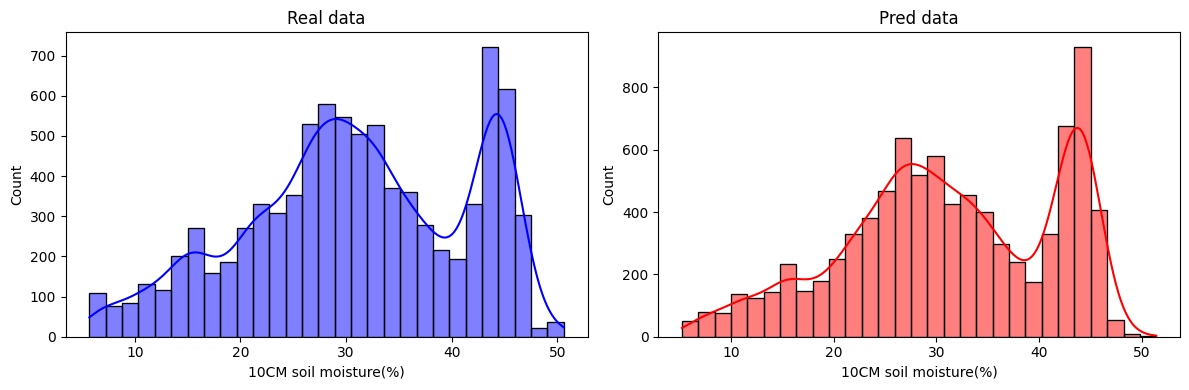

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(y_true, color='blue', label='실제값', kde=True)
plt.title('Real data')
plt.xlabel('10CM soil moisture(%)')

plt.subplot(1,2,2)
sns.histplot(y_pred, color='red', label='예측값', kde=True)
plt.title('Pred data')
plt.xlabel('10CM soil moisture(%)')
plt.tight_layout()
plt.show()

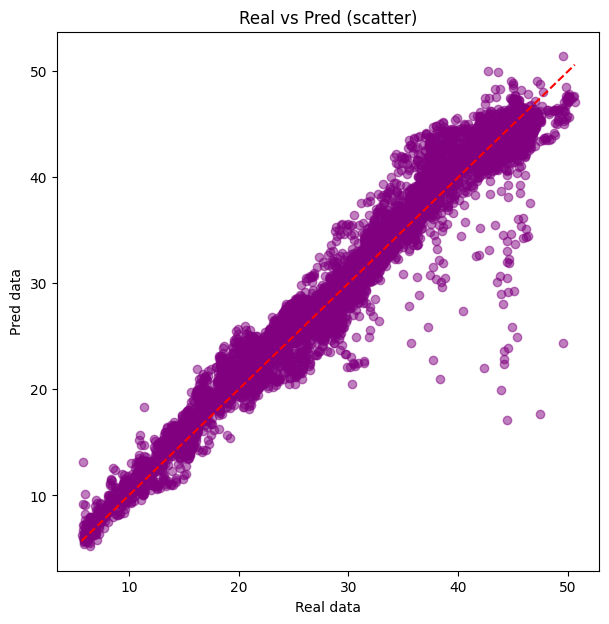

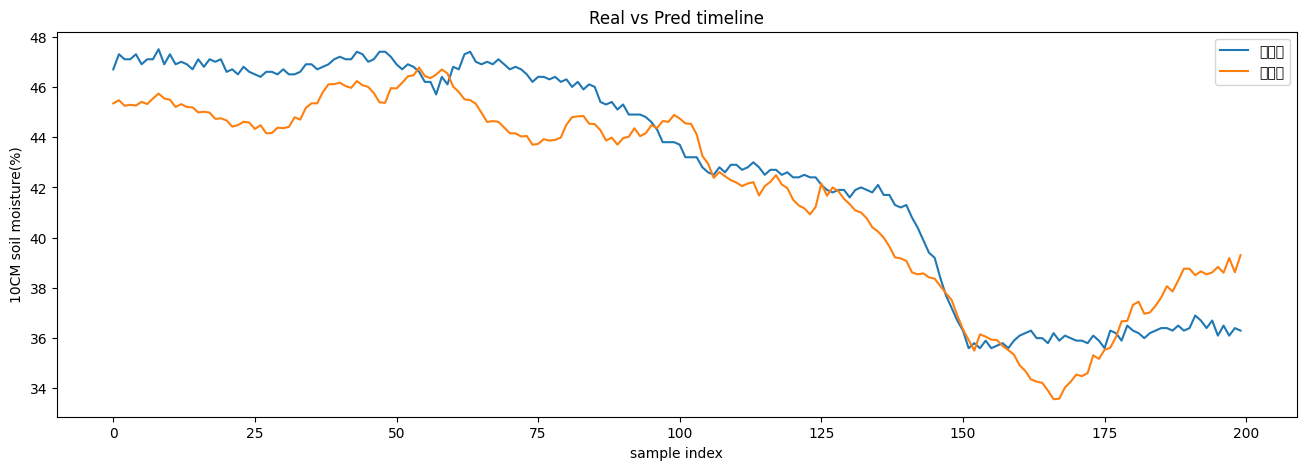

In [28]:
#분산/산점도 & 시계열 라인 그래프
plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.5, color='purple')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Real data')
plt.ylabel('Pred data')
plt.title('Real vs Pred (scatter)')
plt.show()

# 시계열 라인 그래프
plt.figure(figsize=(16,5))
plt.plot(y_true[:200], label='실제값')     # 처음 200개만 보기 좋게
plt.plot(y_pred[:200], label='예측값')
plt.legend()
plt.title('Real vs Pred timeline')
plt.xlabel('sample index')
plt.ylabel('10CM soil moisture(%)')
plt.show()

In [26]:
#정량적 성능 지표
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE(평균제곱오차): {mse:.4f}')
print(f'MAE(평균절대오차): {mae:.4f}')
print(f'R2(결정계수): {r2:.4f}')

MSE(평균제곱오차): 4.5449
MAE(평균절대오차): 1.4155
R2(결정계수): 0.9582
